---
title: "Olist Exploratory Data Analysis"
subtitle: "To Identify Potential Repeat Buyers"
author: "Rainer Kwan"
date: "05/09/22"
format: 
  pdf:
    toc: True
    number-sections: True
    papersize: A4
    geometry:
     - top=5mm
     - left=5mm
     - right=5mm
     - bottom=5mm
    code-block-border-left: '#89CFF0'
jupyter: python3
---

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import geopy.distance
import warnings
import missingno as msno
from math import isnan, ceil
from datetime import timedelta
from geopy.geocoders import Nominatim
from IPython.display import Image
from copy import deepcopy
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.preprocessing import RobustScaler
from category_encoders.cat_boost import CatBoostEncoder
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings('ignore')

# Data Preparation

## Importing Datasets

In [2]:
df_customers = pd.read_csv("data/olist_customers_dataset.csv")
df_customers_geolocation = pd.read_csv("data/olist_geolocation_dataset.csv")
df_order_items = pd.read_csv("data/olist_order_items_dataset.csv")
df_payments = pd.read_csv("data/olist_order_payments_dataset.csv")
df_reviews = pd.read_csv("data/olist_order_reviews_dataset.csv")
df_orders = pd.read_csv("data/olist_orders_dataset.csv")
df_products = pd.read_csv("data/olist_products_dataset.csv")
df_sellers = pd.read_csv("data/olist_sellers_dataset.csv")
df_product_category_name_translation = pd.read_csv(
    "data/product_category_name_translation.csv")

## Transforming and Joining Datasets

In [3]:
df_products = df_products[['product_id', 'product_category_name']]
df_order_items = df_order_items.drop(columns=['shipping_limit_date'])
df_orders = df_orders.drop(columns=['order_approved_at', 'order_delivered_carrier_date'])
df_reviews = df_reviews.drop(columns=['review_comment_title','review_creation_date',
                                      'review_answer_timestamp'])
df_customers_geolocation = df_customers_geolocation.drop(columns=['geolocation_city', 
                                                                  'geolocation_state'])

# Change columns to datetime objects
df_orders['order_estimated_delivery_date'] = pd.to_datetime(
                                                df_orders['order_estimated_delivery_date'])
df_orders['order_purchase_timestamp'] = pd.to_datetime(
                                                df_orders['order_purchase_timestamp'])
df_orders['order_delivered_customer_date'] = pd.to_datetime(
                                                df_orders['order_delivered_customer_date'])

In [4]:
# Translate the product category names from PT to EN
product_cat_names_eng = dict(zip(df_product_category_name_translation \
                                 .product_category_name, 
                                 df_product_category_name_translation \
                                 .product_category_name_english))
df_products.replace({"product_category_name":product_cat_names_eng}, inplace = True)

In [5]:
# Merge product and sellers table to order items table
df_order_items = pd.merge(left=df_order_items, right=df_products, on='product_id', how='left')
df_order_items = pd.merge(left=df_order_items, right=df_sellers, on='seller_id', how='left')

In [6]:
# There are many product categories - 
# it might more be useful to relabel uncommon categories to others
# Relabel minority categories to others
relabel_categories = df_order_items['product_category_name'].value_counts().index[20:]
df_order_items.product_category_name[df_order_items['product_category_name']. \
                                     isin(relabel_categories)] = 'others'

In [7]:
# It is possible for one order to have multiple item types and multiple sellers.
# Count number of items per order id
df_num_items_order_id = df_order_items.groupby('order_id')['order_item_id'].transform("count")
df_order_items = pd.merge(left=df_order_items, right=df_num_items_order_id, 
                          left_index=True, right_index=True)
df_order_items = df_order_items.rename(columns={'order_item_id_x': 'order_item_id', 
                                                 'order_item_id_y': 'item_quantity'})

In [8]:
# To simplify the data, we pick the product/seller 
# belonging to the line item with the highest price.
df_highest_price = df_order_items.groupby('order_id', as_index = False).agg({'price':max})
# Find total sum of price and freight respectively per order id
df_sum_price_freight = df_order_items.groupby('order_id', as_index = False) \
                                     .agg({'price':sum, 
                                           'freight_value':sum})                                                       
# Rename column
df_highest_price = df_highest_price.rename(columns={'price': 'highest_price_item'})
# Join order_items table with highest_price table 
df_order_items = pd.merge(left = df_order_items, right = df_highest_price, 
                          on = 'order_id', how = 'left')
# Retain only order items per order id that contain the highest price
df_order_items = df_order_items[df_order_items['price'] == df_order_items['highest_price_item']]
# Remove duplicate order items if they contain the same highest price 
df_order_items = df_order_items.groupby('order_id',
                                        as_index = False) \
                                        .agg({'product_id': 'first',
                                              'seller_id': 'first',
                                              'product_category_name':'first', 
                                              'seller_zip_code_prefix':'first',
                                              'seller_city':'first',
                                              'seller_state':'first',
                                              'highest_price_item':'first',
                                              'item_quantity':'max'
                                             })
# drop highest_price_item column
df_order_items = df_order_items.drop(columns=['highest_price_item'])
df_order_items['total_price'] = df_sum_price_freight['price']
df_order_items['total_freight_value'] = df_sum_price_freight['freight_value']

In [9]:
# Customers may be able to leave multiple reviews per order_id as one order 
# might contain different sellers for different products.
# Take the average of the review scores and 
# combine all messages to single order_id and review_id
df_reviews = df_reviews.groupby('order_id', as_index = False) \
                        .agg({'review_id': 'first',
                              'review_score':'mean',
                              'review_comment_message': lambda x: 
                                                        ' '.join(map(str, x))
                             })

In [10]:
# Merge the order items table with the reviews table on order_id
df_orders = pd.merge(left=df_orders, right=df_reviews, on='order_id', how='left')

In [11]:
# A single order_id can have multiple payment lines
# To capture the max payment amount, we must sum the payment_value column
# For the remaining columns, we simply need to keep the max values
df_payments = df_payments.groupby('order_id', as_index = False) \
                         .agg({'payment_sequential': max,
                               'payment_installments': max,
                               'payment_value': sum,
                               'payment_type':'first'
                              })

In [12]:
# Merge the order table with the payments and order items tables on order_id
df_orders = pd.merge(left=df_orders, right=df_payments, on='order_id', how='left')
df_orders = pd.merge(left=df_orders, right=df_order_items, on='order_id', how='left')

In [13]:
# There are latitudes and longitudes that do not belong to brazil thus we filter them out
df_customers_geolocation = df_customers_geolocation[
                         (df_customers_geolocation['geolocation_lat'] > -34) &
                         (df_customers_geolocation['geolocation_lat'] < 6)]
# Each zipcode contains multiple latitude/longitude values - find the median
df_customers_geolocation = df_customers_geolocation.rename(
                                                    columns={'geolocation_zip_code_prefix':
                                                             'customer_zip_code_prefix'})
df_customers_geolocation = df_customers_geolocation.groupby('customer_zip_code_prefix') \
                                                   .agg({'geolocation_lat': 'median',
                                                         'geolocation_lng': 'median'})

In [14]:
# Merge the customers table with the geolocation table on customer_zip_code_prefix a
df_customers = pd.merge(left=df_customers, right=df_customers_geolocation,
                        on='customer_zip_code_prefix', how='left')
df_customers = df_customers.rename(columns={'geolocation_lat': 'customer_lat', 
                                            'geolocation_lng': 'customer_lng'})
# Merge the customers table with the orders table on customer_id
df_customers = pd.merge(left=df_customers, right=df_orders, on='customer_id', how='left')

## Problem Scoping

In order to proceed with further data preparation and analysis, we need to establish the definition of a repeat customer.

### Investigation

In [15]:
# Create new feature: Number of orders per customer.
num_orders_per_customer = df_customers.groupby('customer_unique_id')['order_id'].nunique()
num_orders_per_customer = num_orders_per_customer.to_dict()
df_customers['num_orders_per_customer'] = df_customers['customer_unique_id'] \
                                         .map(num_orders_per_customer)
# Plot num_orders_per_customer
display(df_customers['num_orders_per_customer'].value_counts())
# Find % of returning (loyal) customers
returning_customers_percent = len(df_customers[df_customers['num_orders_per_customer'] > 1]) \
                              /len(df_customers)*100
print(f"The % of customers with >1 order is {returning_customers_percent:.2f}%")

1     93099
2      5490
3       609
4       120
5        40
6        36
7        21
17       17
9         9
Name: num_orders_per_customer, dtype: int64

The % of customers with >1 order is 6.38%


The percentage of customers with more than 1 order is very low (6.38%). Thus, Olist has difficulty retaining their customers after their first order. For each customer, we aim to predict if they will become repeat customers i.e. they will place additional orders after their first.

Next, we have to consider the timeframe between a customer's first order and their potential second order. If a customer fails to place their order within the timeframe, they are not considered repeat customers. If they do, they are considered repeat customers and are valuable to the company.

In [16]:
# Identify repeat customers
df_repeat_customers = df_customers[df_customers['num_orders_per_customer'] > 1]
df_repeat_customers = df_repeat_customers.groupby(['customer_unique_id', 'order_id'],
                                          as_index = False) \
                                         .agg({'order_purchase_timestamp':'first'}) \
                                         .sort_values(['customer_unique_id',
                                                       'order_purchase_timestamp'], 
                                          ascending=[True,True])
# Calculate time difference first and second order
first_order_timestamp = df_repeat_customers.groupby('customer_unique_id') \
                                            .nth([0])['order_purchase_timestamp']
second_order_timestamp = df_repeat_customers.groupby('customer_unique_id') \
                                            .nth([1])['order_purchase_timestamp']
time_diff_1st_2nd_order = (second_order_timestamp - first_order_timestamp) \
                                            .apply(lambda x: x.days)
df_time_diff_1st_2nd_order = pd.DataFrame(
                            {'customer_unique_id':time_diff_1st_2nd_order.index,
                             'time_diff_1st_2nd_order':time_diff_1st_2nd_order.values})
df_customers = pd.merge(left = df_customers, right = df_time_diff_1st_2nd_order, 
                        on = 'customer_unique_id', how = 'left')

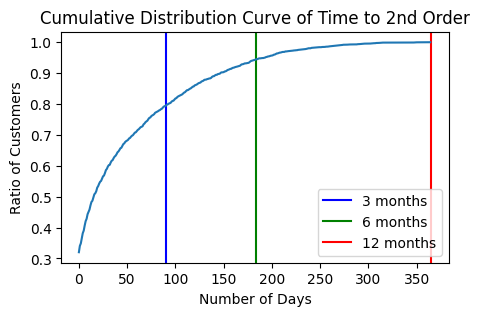

In [17]:
# Plot the CDF of time difference between first and second orders for each customer
df_repeat_customers = df_customers[df_customers['num_orders_per_customer'] > 1]
count, bins_count = np.histogram(df_repeat_customers['time_diff_1st_2nd_order'], bins=365)
pdf = count / sum(count)
plt.figure(figsize=(5, 3))
days_30_line = plt.axvline(x = 90, color = 'b', label = '3 months');
days_90_line = plt.axvline(x = 183, color = 'g', label = '6 months');
days_365_line = plt.axvline(x = 365, color = 'r', label = '12 months');
cdf = plt.plot(np.cumsum(pdf));
plt.legend(handles = [days_30_line, days_90_line, days_365_line], 
           labels  = ['3 months', '6 months', '12 months'])
plt.title('Cumulative Distribution Curve of Time to 2nd Order')
plt.xlabel('Number of Days')
plt.ylabel('Ratio of Customers')
plt.show()

About 90% of customers who placed their second order did so within 6 months (183 days). Thus, we shall set the timeframe to 183 days.

### Additional Data Preparation

In [18]:
# Create intermediate feature 'first_purchase_timestamp'
df_first_purchase = df_customers.groupby('customer_unique_id', as_index = False) \
                                .agg({'order_purchase_timestamp':min})
df_first_purchase = df_first_purchase.rename(columns={'order_purchase_timestamp': 
                                                      'first_purchase_timestamp'})
# Add 'first_purchase_timestamp' feature to main customers table
df_customers = pd.merge(left=df_customers, right=df_first_purchase,
                        on='customer_unique_id', how = 'left')

In [19]:
# Remove customers whose first purchase falls within latest 6 months (183 days)
last_timestamp = df_customers['first_purchase_timestamp'].sort_values().iat[-1]
df_customers = df_customers[df_customers['first_purchase_timestamp'] 
                            < (last_timestamp - timedelta(days=183))]

### Create the Target Variable: 'repeat customer'

In [20]:
# Function to determine whether a customer churns or not
churn_day_limit = 183

def determine_repeat_customer(time_diff):
  if isnan(time_diff):
    return 0
  elif time_diff >= churn_day_limit:
    return 0
  else:
    return 1

# Create 'repeat_customer' target variable.
df_customers['repeat_customer'] = df_customers['time_diff_1st_2nd_order'] \
.apply(determine_repeat_customer)

In [21]:
# Retain only first orders
df_customers = df_customers[df_customers['first_purchase_timestamp'] == 
                            df_customers['order_purchase_timestamp']]
# Rename Dataframe to df out of convenience since we have arrived at our final dataset
df = df_customers

## Feature Engineering

### Create New Temporal Features

In [22]:
# Breakdown order_purchase_timestamp into year, month, day, day of week, is weekend
df['year'] = pd.DatetimeIndex(df['order_purchase_timestamp']).year
df['month'] = pd.DatetimeIndex(df['order_purchase_timestamp']).month
df['day'] = pd.DatetimeIndex(df['order_purchase_timestamp']).day
df['day_of_week'] = pd.DatetimeIndex(df['order_purchase_timestamp']).dayofweek
df['is_weekend'] = (df['day_of_week'] > 4).astype(int)

# 'days_from_purchase_to_est_delivery' is the number of days 
# between the date of purchase and the estimated delivery date
df['purchase_to_est_delivery'] = (df['order_estimated_delivery_date'] 
                                  - df['order_purchase_timestamp']).astype('timedelta64[D]')

# 'days_from_est_delivery_to_actual' is the number of days 
# between the estimated delivery date and the actual delivery date
df['est_delivery_to_actual'] = (df['order_delivered_customer_date'] 
                                - df['order_estimated_delivery_date']).astype('timedelta64[D]')

# 'days_from_purchase_to_actual' is the number of days 
# between the date of purchase date and the actual delivery date
df['purchase_to_actual'] = (df['order_delivered_customer_date'] 
                                - df['order_purchase_timestamp']).astype('timedelta64[D]')

# Drop the two delivery timestamp columns and timestamp
df = df.drop(columns=['order_delivered_customer_date', 'order_estimated_delivery_date',
                      'order_purchase_timestamp'])

### Create Features from Geospatial Data

In [23]:
# Reuse customer geolocation table to find seller geolocation
df_sellers_geolocation = df_customers_geolocation.reset_index()
df_sellers_geolocation = df_sellers_geolocation \
                        .rename(columns={'customer_zip_code_prefix': 
                                         'seller_zip_code_prefix'})
# Merge df with seller geolocation table
df = pd.merge(left = df, right = df_sellers_geolocation, 
              on = "seller_zip_code_prefix", how = "left")
# Rename geolocation columns
df = df.rename(columns={'geolocation_lat': 'seller_lat', 'geolocation_lng': 'seller_lng'})

# Function to calculate distance between geographical coordinates
def distance(customer_lat, customer_lng, seller_lat, seller_lng):
    if any([pd.isnull(val) for val in locals().values()]):
        return None
    else:
        return geopy.distance.geodesic((customer_lat, customer_lng), 
                                       (seller_lat,seller_lng)).km

coordinate_cols = ['customer_lat', 'customer_lng', 'seller_lat', 'seller_lng']
# Create new feature 'customer_seller_dist'
df['customer_seller_dist'] = df[coordinate_cols] \
                            .apply(lambda x: distance(x['customer_lat'], 
                                                      x['customer_lng'], 
                                                      x['seller_lat'], 
                                                      x['seller_lng']), axis=1)

In [24]:
# Apply finishing touches and preview final table
df = df.reset_index()
df = df.drop(columns = ['index'])

# Remove unneeded and intermediate/transitory columns
df_customers = df_customers.drop(
                columns=['customer_id', 'customer_unique_id', 'order_id', 'review_id',
                         'product_id', 'seller_id', 'customer_zip_code_prefix', 
                         'time_diff_1st_2nd_order', 'num_orders_per_customer', 
                         'first_purchase_timestamp', 'review_comment_message',
                         'order_delivered_customer_date', 'order_estimated_delivery_date', 
                         'order_purchase_timestamp'])

# Reorder columns
df = df[['customer_city', 'customer_state', 'seller_city', 'seller_state', 'customer_lat', 
         'customer_lng','seller_lat','seller_lng', 'customer_seller_dist', 'review_score',
         'purchase_to_est_delivery', 'est_delivery_to_actual', 'purchase_to_actual', 
         'payment_sequential', 'payment_installments', 'payment_value','payment_type', 
         'total_price','total_freight_value', 'product_category_name', 'item_quantity',
         'year', 'month', 'day', 'day_of_week', 'is_weekend', 'order_status',
         'repeat_customer']]

# Standardize all null values to np.nan
df.fillna(np.nan, inplace = True)

# Data Quality Investigation

## Duplicate Data

In [25]:
# Find duplicates
num_duplicates = df.duplicated().sum()
print(f"There are {num_duplicates} duplicates in the dataset.")

There are 10 duplicates in the dataset.


In [26]:
# Check one of the duplicates
dups = df[df.duplicated(keep=False)].sort_values(by=['payment_value']).tail(2)
for i in range(0,28,6):
    display(dups.iloc[:2,i:i+5])

,customer_city,customer_state,seller_city,seller_state,customer_lat
62897,campinas,SP,teresopolis,RJ,-22.87877
59234,campinas,SP,teresopolis,RJ,-22.87877


,seller_lat,seller_lng,customer_seller_dist,review_score,purchase_to_est_delivery
62897,-22.418057,-42.976309,419.759563,5.0,27.0
59234,-22.418057,-42.976309,419.759563,5.0,27.0


,purchase_to_actual,payment_sequential,payment_installments,payment_value,payment_type
62897,6.0,1.0,1.0,1149.83,boleto
59234,6.0,1.0,1.0,1149.83,boleto


,total_freight_value,product_category_name,item_quantity,year,month
62897,95.83,others,1.0,2018,4
59234,95.83,others,1.0,2018,4


,day_of_week,is_weekend,order_status,repeat_customer
62897,0,0,delivered,1
59234,0,0,delivered,1


The orders look like duplicate entries in the database thus we shall remove them.

In [27]:
# Drop duplicates
num_before = len(df)
df = df.drop_duplicates()
num_after = len(df)
print(f" {num_before - num_after} rows have been dropped from the dataset.")

 10 rows have been dropped from the dataset.


## Missing Data

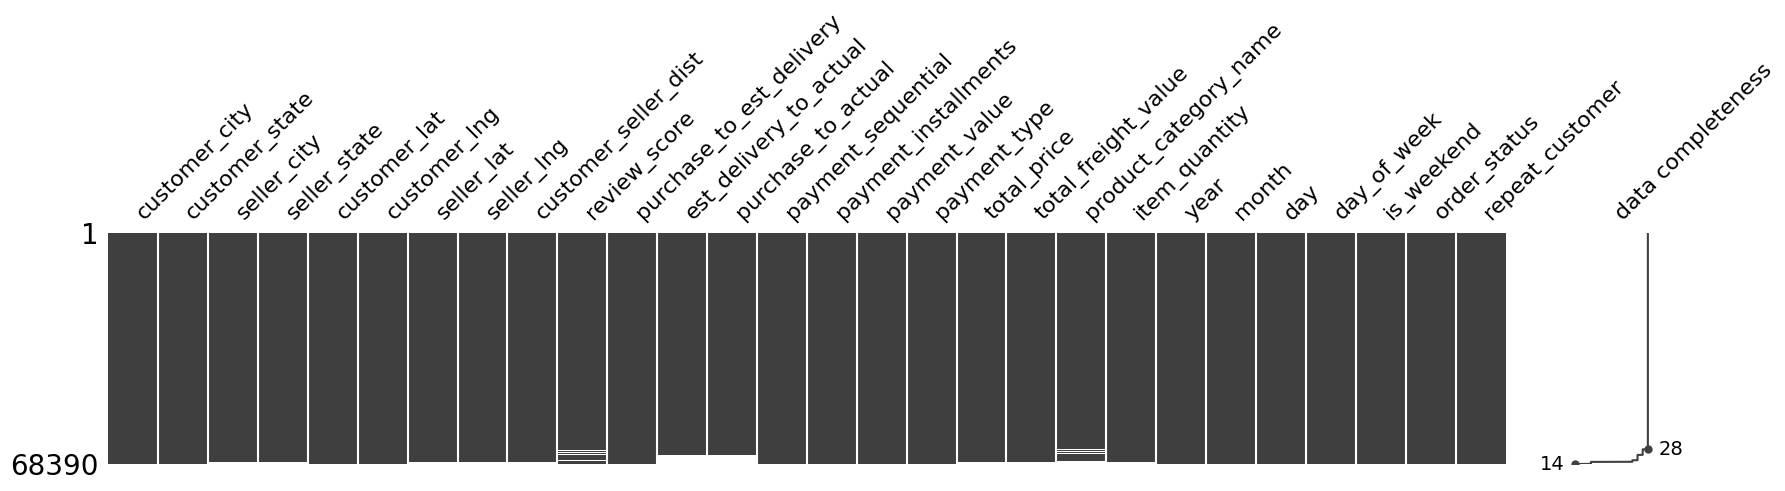

In [28]:
import missingno as msno

msno.matrix(df, figsize=(20, 3), labels=True, sort="descending");

About 28% of customers have some missing data. Let's look at the missing data by feature.

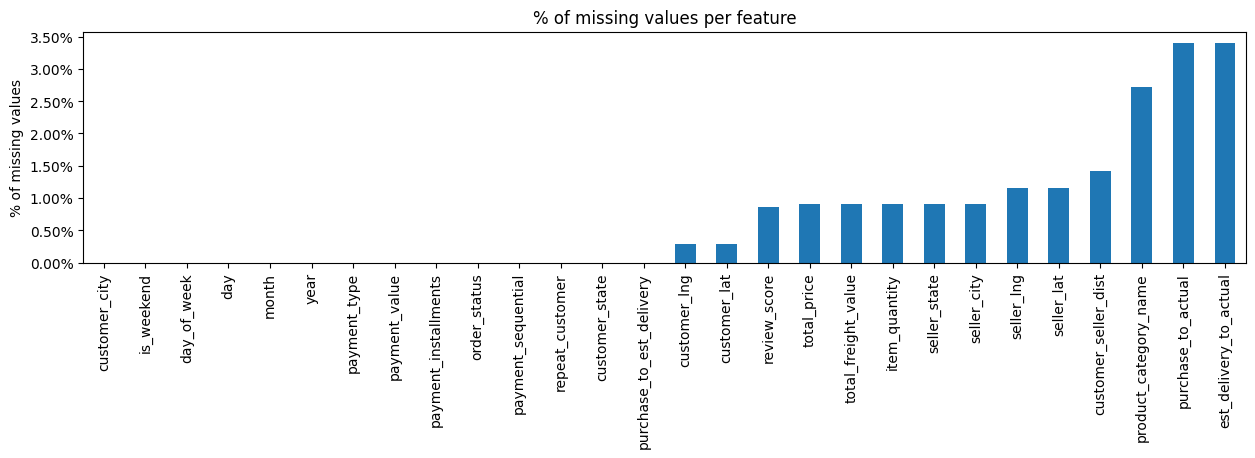

In [29]:
ax = df.isna().mean().apply(lambda x: round(100*x,2)).sort_values().plot(
    kind="bar", figsize=(15, 3),
    title="% of missing values per feature",
    ylabel="% of missing values");

ax.yaxis.set_major_formatter(mtick.PercentFormatter())

`Great! Most of our features have few (<5%) or no missing values. We will replace these missing values later via imputation during the modelling process.`

## Outliers Detection

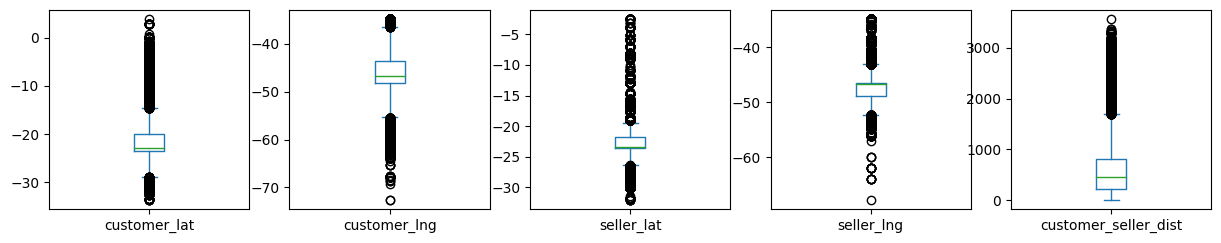

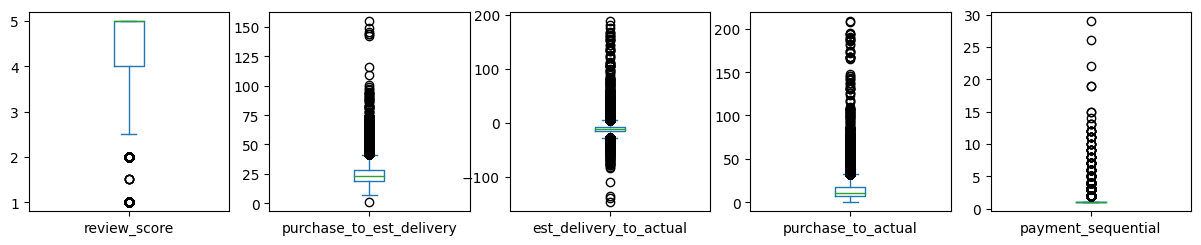

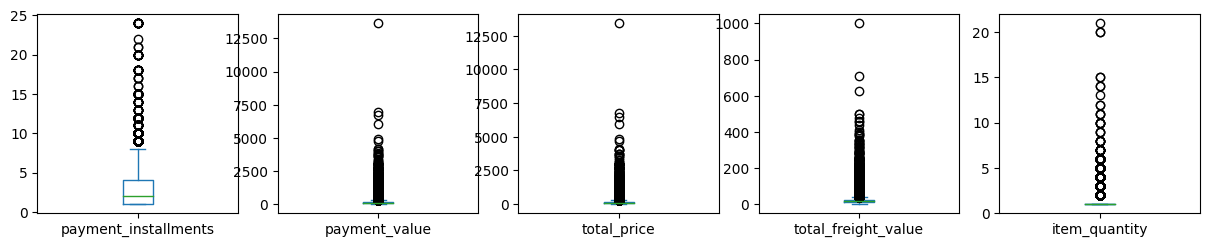

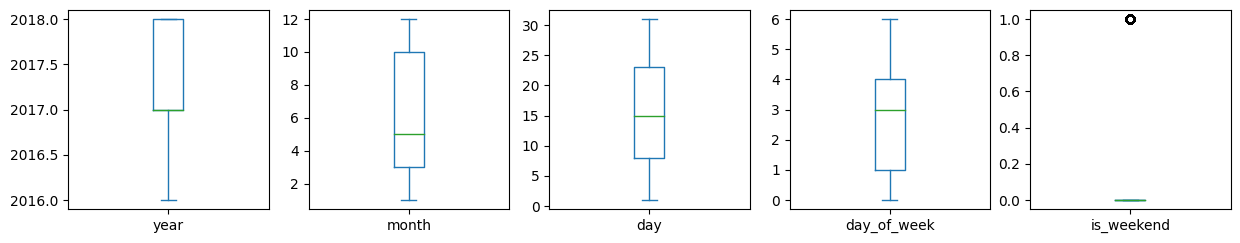

In [30]:
for i in range(0,20,5):
    df.select_dtypes(include=[np.number]) \
      .iloc[:,i:i+5] \
      .plot(kind="box", subplots=True, layout=(5,5), figsize=(15,15))

There is a distinct outlier in payment_value, total_price and total_freight_value.

In [31]:
display(df.sort_values(by='payment_value', ascending=False)[['product_category_name',
                                                             'item_quantity',
                                                             'payment_value']] \
                                                             .head(1))
display(df.sort_values(by='total_freight_value', ascending=False)[['product_category_name',
                                                                   'item_quantity',
                                                                   'total_price',
                                                                   'total_freight_value']] \
                                                                   .head(1))

,product_category_name,item_quantity,payment_value
4190,others,8.0,13664.08


,product_category_name,item_quantity,total_price,total_freight_value
12563,furniture_decor,6.0,419.4,1002.29


The first customer above paid for 8 items while the second customer ordered 6 units of furniture which explains the high freight cost.

# Data Exploration

## Target Variable - Repeat Customer

In [32]:
display(df['repeat_customer'].value_counts(normalize=True))

0    0.966121
1    0.033879
Name: repeat_customer, dtype: float64

The target variable is highly skewed! Only 3.39% of customers ordered a 2nd time within 6 months of their first purchase. 

## Payment Features

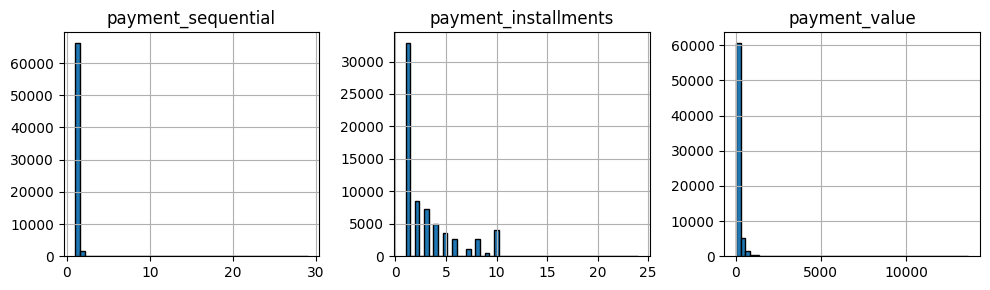

In [33]:
cols = ['payment_sequential','payment_installments','payment_value']
df[cols].hist(bins=50, figsize=(10, 3), layout=(1, 3), edgecolor="black")
plt.tight_layout();

counts      %  mean payment value  \
payment_type repeat_customer                                      
boleto       0                 13637  96.68              144.30   
             1                   469   3.32              148.37   
credit_card  0                 49894  96.61              166.49   
             1                  1753   3.39              148.11   
debit_card   0                   691  97.05              104.58   
             1                    21   2.95               80.49   
voucher      0                  1850  96.15              127.67   
             1                    74   3.85               92.83   

                              mean payment installments  \
payment_type repeat_customer                              
boleto       0                                     1.00   
             1                                     1.00   
credit_card  0                                     3.56   
             1                                     4.13   
debit_card   0                                     1.00   
             1                                     1.00   
voucher      0                                     1.49   
             1                                     1.34   

                              mean payment sequentials  
payment_type repeat_customer                            
boleto       0                                    1.00  
             1                                    1.00  
credit_card  0                                    1.02  
             1                                    1.03  
debit_card   0                                    1.03  
             1                                    1.00  
voucher      0                                    2.11  
             1                                    1.89

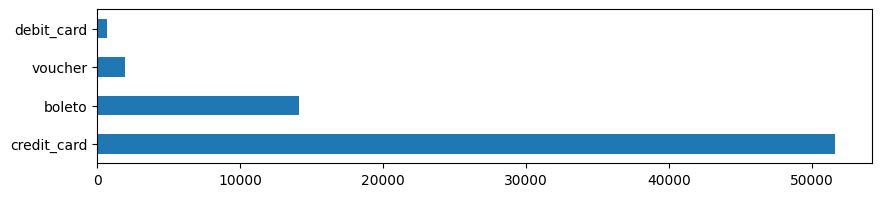

In [34]:
# Plot payment types, sequentials and instalallments
counts = df.groupby('payment_type')['repeat_customer'] \
           .value_counts(dropna=False)
percent = df.groupby('payment_type')['repeat_customer'] \
           .value_counts(dropna=False, normalize=True)
values = df.groupby(['payment_type','repeat_customer']) \
            .agg({'payment_value':'mean'})['payment_value']
installments = df.groupby(['payment_type','repeat_customer']) \
                         .agg({'payment_installments':'mean'})['payment_installments']
sequentials = df.groupby(['payment_type','repeat_customer']) \
                         .agg({'payment_sequential':'mean'})['payment_sequential']
table_1 = pd.concat([counts, percent, values, installments, sequentials], axis=1, 
                  keys=['counts', '%', 'mean payment value',
                        'mean payment installments', 'mean payment sequentials'])
table_1['%'] = table_1['%'].apply(lambda x:x*100)
table_1 = table_1.apply(lambda x: round(x,2))
df['payment_type'].value_counts().plot(kind='barh', figsize=(10,2));
display(table_1)

Observations: <br>
    1. Credit card is by far the most common type, with a mean payment stallments of 3.56. <br>
    2. Customers who use credit card for payment pay more for the first order on average. <br>
    3. Most people who paid via voucher used 2 vouchers on average. <br>
    4. Customers who paid by voucher are marginally more likely to make a second order.

## Order Features

counts       %  mean distance  mean review score
order_status repeat_customer                                                  
approved     0                     2  100.00         134.51               2.50
canceled     0                   390   93.75         485.01               1.71
             1                    26    6.25         625.92               2.92
created      0                     5  100.00            NaN               2.33
delivered    0                 63832   96.64         615.76               4.10
             1                  2220    3.36         564.55               4.11
invoiced     0                   232   96.67         531.81               1.59
             1                     8    3.33         769.86               3.19
processing   0                   280   97.90         687.17               1.24
             1                     6    2.10         659.63               1.67
shipped      0                   806   95.27         790.06               1.98
             1                    40    4.73         605.89               2.18
unavailable  0                   526   96.87         801.71               1.50
             1                    17    3.13            NaN               2.85

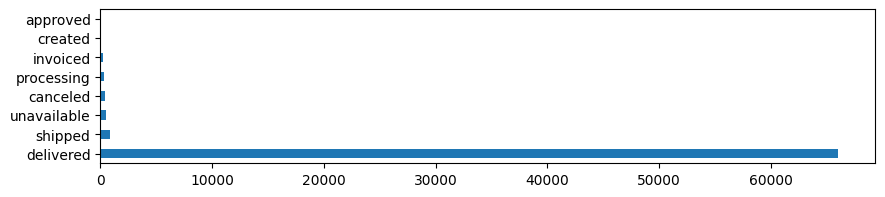

In [35]:
counts = df.groupby('order_status')['repeat_customer'] \
           .value_counts()
percent = df.groupby('order_status')['repeat_customer'] \
            .value_counts(normalize=True)
review_scores = df.groupby(['order_status','repeat_customer']) \
                  .agg({'review_score':'mean'})['review_score']
distances = df.groupby(['order_status','repeat_customer']) \
              .agg({'customer_seller_dist':'mean'})['customer_seller_dist']
table_2 = pd.concat([counts, percent, distances, review_scores], 
                    axis=1, keys=['counts', '%',
                                  'mean distance','mean review score'])
table_2['%'] = table_2['%'].apply(lambda x:x*100)
table_2 = table_2.apply(lambda x: round(x,2))
df['order_status'].value_counts().plot(kind='barh', figsize=(10,2));
display(table_2)

Observations: <br>
    1. Delivered orders have a high mean review score as compared to the rest of the orders in other statuses. <br>
    2. The order status of a customer's first order does not appear to have much importance on whether the customer will become a repeat customer. <br>
    3. The 'shipped' and 'unavailable' statuses have low review scores and high distances on average in comparison to the rest of the statuses.

## Product Features

,product_category_name,repeat_customer,counts,%,mean review scores
15,fashion_bags_accessories,1,83,6.17,4.04
5,bed_bath_table,1,348,5.39,3.90
17,furniture_decor,1,239,5.31,3.91
33,sports_leisure,1,253,4.51,4.19
21,health_beauty,1,188,3.49,4.25


,product_category_name,repeat_customer,counts,%,mean review scores
10,cool_stuff,0,2934,98.49,4.17
8,consoles_games,0,831,98.11,4.05
12,electronics,0,1728,98.07,4.03
0,auto,0,2397,97.80,4.01
40,watches_gifts,0,3233,97.67,4.03


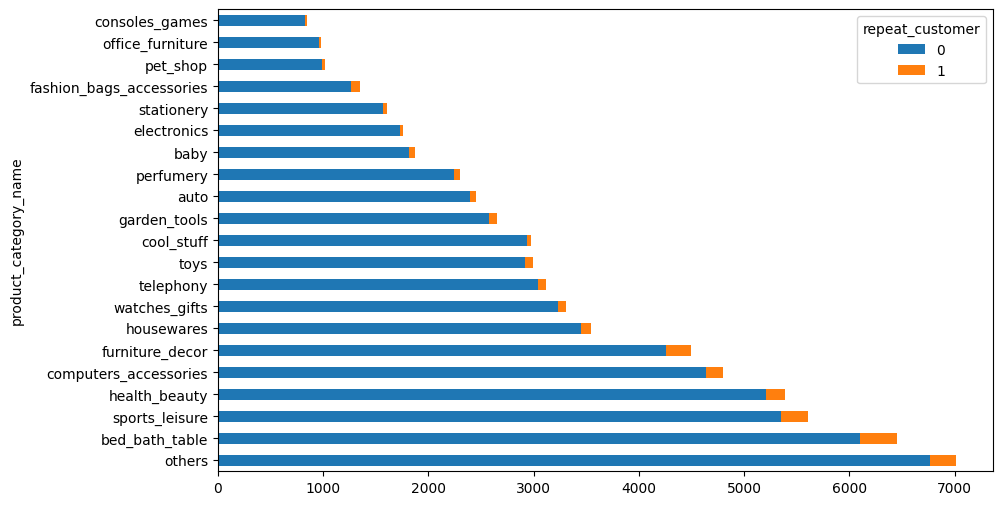

In [36]:
# Most popular item categories
sort_ix = df.groupby('product_category_name')['repeat_customer'] \
            .count().reset_index(name='count') \
            .sort_values(by='count', ascending=False) \
            ['product_category_name'].values.tolist()

stacked_bar_chart = df.groupby('product_category_name')['repeat_customer'] \
                      .value_counts() \
                      .unstack()
stacked_bar_chart.reindex(sort_ix).plot(kind="barh", 
                                        figsize=(10, 6), 
                                        stacked=True);

counts = df.groupby('product_category_name')['repeat_customer'] \
           .value_counts()
percent = df.groupby('product_category_name')['repeat_customer'] \
            .value_counts(normalize=True)
review_scores = df.groupby(['product_category_name','repeat_customer']) \
                  .agg({'review_score':'mean'})['review_score']
table_3 = pd.concat([counts, percent, review_scores], axis=1, 
                    keys=['counts', '%', 'mean review scores'])
table_3['%'] = table_3['%'].apply(lambda x:x*100)
table_3 = table_3.apply(lambda x: round(x,2)).reset_index()
display(table_3[table_3['repeat_customer'] == 1].sort_values('%', ascending=False).head(5))
display(table_3[table_3['repeat_customer'] == 0].sort_values('%', ascending=False).head(5))

Observations: <br>
    1. The 'bed_bath_table' category had the 2nd most orders of any product category and the 2nd highest percentage of returning customers. <br>
    2. The review score appears to have little correlation with the category of product purchased for a customer's first order and whether the customer will become a repeat customer.

In [37]:
df_item_qty = deepcopy(df)
df_item_qty.item_quantity[df_item_qty['item_quantity'] > 1] = '>1.0'
counts = df_item_qty.groupby('item_quantity')['repeat_customer'] \
                    .value_counts()
percent = df_item_qty.groupby('item_quantity')['repeat_customer'] \
                    .value_counts(normalize=True)
table_4 = pd.concat([counts, percent], axis=1, keys=['counts', '%'])
table_4['%'] = table_4['%'].apply(lambda x:round(x*100,2))
display(table_4)

counts      %
item_quantity repeat_customer               
1.0           0                 59133  96.78
              1                  1969   3.22
>1.0          0                  6348  95.23
              1                   318   4.77

## Temporal Features

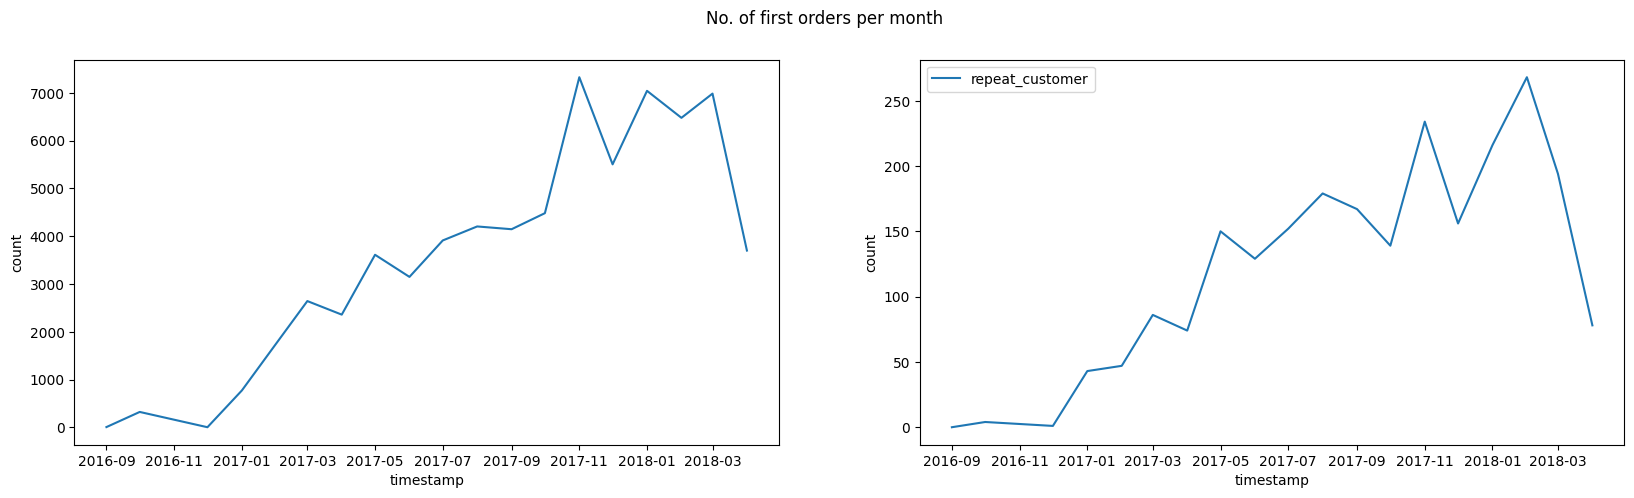

In [38]:
# Plot number of first orders for each month
customers_time = pd.to_datetime(df.year.astype(str) + '/' + df.month.astype(str))
line_1 = customers_time.value_counts()
table_5 = pd.concat([customers_time, df['repeat_customer']], axis = 1,
          keys = ['timestamp', 'repeat_customer'])
line_2 = table_5.groupby(['timestamp'], as_index=False) \
                .sum()
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(20,5))
line_1.plot(ax = axes[0],subplots=True, title='No. of first orders per month', 
            xlabel = 'timestamp', ylabel = 'count');
line_2.plot(ax = axes[1], x='timestamp', y='repeat_customer',
            subplots=True, ylabel = 'count');

Observations:
1. There was a surge in orders at the beginning of 2017 and it continued till the start of 2018 before tapering off.
2. The number of repeat customers also follows the same pattern as described above.

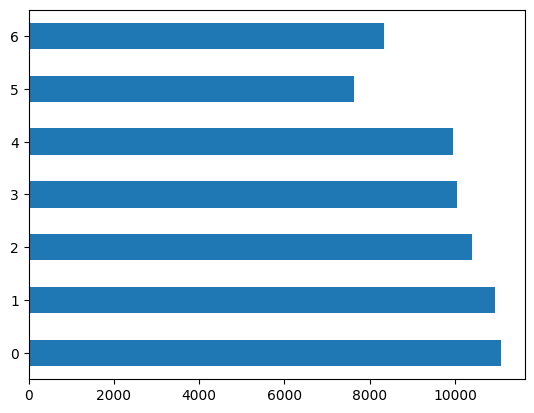

In [39]:
# Plot distribution of first orders across days of week
df['day_of_week'].value_counts().sort_index().plot(kind='barh');

More orders are placed on weekdays as compared to weekends.

In [40]:
# Distribution of delivery times
display(df.groupby('repeat_customer') \
          .agg({'purchase_to_est_delivery':'mean',
                'est_delivery_to_actual':'mean',
                'purchase_to_actual':'mean',
                'customer_seller_dist':'mean'}))

,purchase_to_est_delivery,est_delivery_to_actual,purchase_to_actual,customer_seller_dist
repeat_customer,,,,
0,24.270307,-11.437449,13.365233,617.265661
1,24.425119,-12.291892,12.715766,566.604572


On average, repeat customers experience slightly better actual delivery times than non-repeat customers.

## Geospatial Features

The Tableau Public visualisation can be found at [this link](https://public.tableau.com/views/OlistGeographicalDistributionofCustomersandSellers/Dashboard1?:language=en-US&:display_count=n&:origin=viz_share_link).

The bulk of orders were made by customers who live in urbanized areas (e.g. big cities like Sao Paolo and Belo Horizonte) as shown by the density of the states SP and MG, which are highly urbanized.

## Feature Correlation

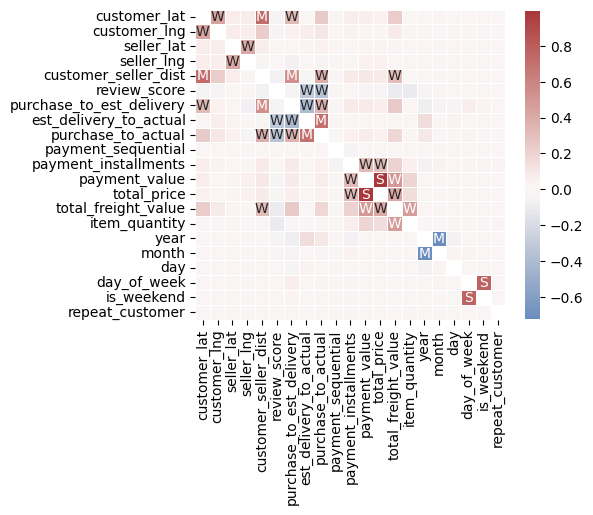

In [41]:
df_corr = df.corr(method="pearson")
labels = np.where(np.abs(df_corr) > 0.75, "S",
                  np.where(np.abs(df_corr) > 0.5, "M",
                           np.where(np.abs(df_corr) > 0.25, "W", "")))
# Plot correlation matrix
plt.figure(figsize=(5, 5))
sns.heatmap(df_corr, mask=np.eye(len(df_corr)), square=True,
            center=0, annot=labels, fmt='', linewidths=.5,
            cmap="vlag", cbar_kws={"shrink": 0.8});

Most numeric features only show weak linear correlation with the target variable. It appears that there is no one main factor in determining whether a first-time customer becomes a repeat customer. However, complex non-linear relationships between multiple features might be important factors in determining repeat customers as well, which cannot be displayed in this simple plot.

# Feature Engineering

**NOTE: We will assume that there is a separate test set and we assume all imputations and encodings performed here are exclusively for the training set.**

## Impute Missing Values

In [42]:
# Filter numeric features with missing values
numeric_features = df.select_dtypes(include=[np.number]).columns
df_miss_num = df[numeric_features].loc[:,df[numeric_features] \
                                      .isna().any(axis = 0)]

# Display missing numeric data count
display(df_miss_num.isna().sum())
index = df_miss_num[df_miss_num .isna().any(axis=1)].head(1).index
display(df_miss_num.iloc[index,:6])

customer_lat               190
customer_lng               190
seller_lat                 785
seller_lng                 785
customer_seller_dist       970
review_score               589
est_delivery_to_actual    2334
purchase_to_actual        2334
payment_sequential           1
payment_installments         1
payment_value                1
total_price                622
total_freight_value        622
item_quantity              622
dtype: int64

,customer_lat,customer_lng,seller_lat,seller_lng,customer_seller_dist,review_score
14,-23.562134,-46.68734,-21.75769,-48.829768,297.333922,NaN


We impute numerical features using IterativeImputer which imputes missing values by modeling each feature as a function of other features in a round-robin fashion.

In [43]:
# Impute numeric features with missing values via multivariate imputation
imp_mean = IterativeImputer(random_state=0)
df[numeric_features] = imp_mean.fit_transform(df[numeric_features])
display(df[df_miss_num.columns].iloc[index,:6])

,customer_lat,customer_lng,seller_lat,seller_lng,customer_seller_dist,review_score
14,-23.562134,-46.68734,-21.75769,-48.829768,297.333922,3.297155


In [44]:
# Filter categorical features with missing values
categorical_features = df.select_dtypes(exclude=[np.number]).columns
df_miss_cat = df[categorical_features].loc[:,df[categorical_features] \
                                      .isna().any(axis = 0)]
# Display missing categorical data count
display(df_miss_cat.isna().sum())
index = df_miss_cat[df_miss_cat.isna().any(axis=1)].head(1).index
display(df_miss_cat.iloc[index,:6])

seller_city               622
seller_state              622
payment_type                1
product_category_name    1857
dtype: int64

,seller_city,seller_state,payment_type,product_category_name
5,sao paulo,SP,credit_card,NaN


We impute categorical features by simplying filling in null values with 'Missing', and giving them its own categories.

In [45]:
# Impute categorical features with missing values by filling in 'missing'
imp = SimpleImputer(strategy='constant', fill_value='missing')
df[categorical_features] = imp.fit_transform(df[categorical_features])
# Display missing categorical data count
display(df[df_miss_cat.columns].iloc[index,:])

,seller_city,seller_state,payment_type,product_category_name
5,sao paulo,SP,credit_card,missing


In [46]:
print('There are now ' + str(df.isna().any().sum()) + ' missing values!')

There are now 0 missing values!


## Scale numerical variables

We use sklearn's RobustScaler as it scales features using statistics that are robust to outliers.

In [47]:
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_features.remove('repeat_customer')
# Before scaling
display(df[numeric_features].iloc[:1,:6])
df[numeric_features] = RobustScaler().fit_transform(df[numeric_features])
# After Scaling
display(df[numeric_features].iloc[:1,:6])

,customer_lat,customer_lng,seller_lat,seller_lng,customer_seller_dist,review_score
0,-20.50207,-47.396822,-23.48488,-46.36655,346.995011,4.0


,customer_lat,customer_lng,seller_lat,seller_lng,customer_seller_dist,review_score
0,0.670422,-0.164022,-0.038394,0.168547,-0.175063,-0.967252


## Encode categorical variables

We encode categorical features using CatBoost as it is more effective than other methods such as one-hot encoding and target encoding, without introducing as much overfitting.

In [48]:
cbe_encoder = CatBoostEncoder()
df[categorical_features] = cbe_encoder.fit_transform(df[categorical_features], df['repeat_customer'])
df[categorical_features].head(1)

,customer_city,customer_state,seller_city,seller_state,payment_type,product_category_name,order_status
0,0.033879,0.033879,0.033879,0.033879,0.033879,0.033879,0.033879


# Feature Importance Plot

We use a Random Forest Classifier to quickly evaluate the importance of features

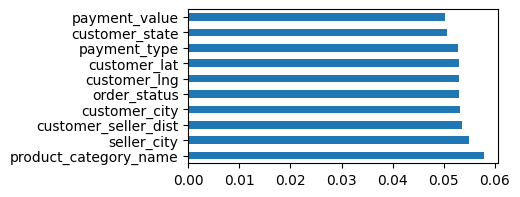

In [49]:
X, y = df.drop(columns=['repeat_customer']), df['repeat_customer'], 
model = RandomForestClassifier()
model.fit(X, y)
feat_importances = pd.Series(model.feature_importances_, index=X.columns).nlargest(10).plot(kind='barh', figsize=(4,2));

These 10 features are most useful in predicting the target variable 'repeat_customer'.